In [1]:
from Rosenbrock import Rosenbrock_dist
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import scipy as sp
import timeit

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [2]:
Bana_dist = Rosenbrock_dist()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


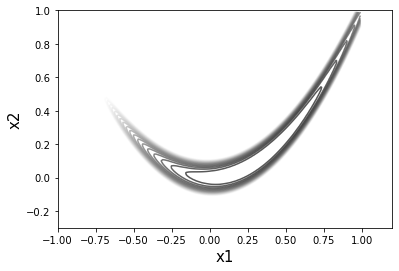

In [3]:
fig,ax = Bana_dist.draw_post()

In [4]:
def negative_log_posterior(mu):
    return tf.negative(Bana_dist.joint_log_post(mu))[0]

In [5]:
mu_init = tf.constant([[-0.6,0.4]])
Bana_dist.joint_log_post(mu_init)
ax.scatter(mu_init[0][0],mu_init[0][1] , c = 'r',zorder=10)
ax.set_title('Initial position',fontsize=20)
# fig.savefig('/Users/zhouji/Documents/Presentations/IRTG 2020/figs/init.png',dpi=300)

Text(0.5, 1, 'Initial position')

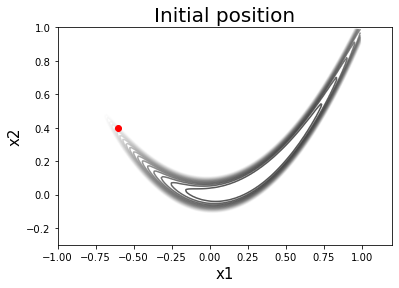

In [6]:
fig

In [7]:
# Function for printing
def loss(mu):
    lost =  negative_log_posterior(mu)
    return lost

# Function for tensorflow optimizer
def loss_minimize():
    lost =  negative_log_posterior(mu)
    return lost

In [8]:
Adam = tf.keras.optimizers.Adam(
    learning_rate=0.03, beta_1=0.9, beta_2=0.999, epsilon=1e-08
)
cost_A = []
mu_list = [mu_init]
mu = tf.Variable(mu_init)
start = timeit.default_timer()

for step in range(300):

    Adam.minimize(loss_minimize, var_list=[mu])
    cost_A.append(loss(mu).numpy())

    mu_list.append(mu.numpy())
end = timeit.default_timer()

In [9]:
mu_list[-1]

array([[0.16487178, 0.02676925]], dtype=float32)

In [10]:
Mu_array = np.array(mu_list)

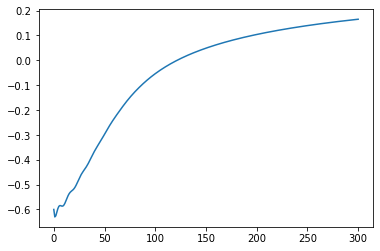

In [11]:
plt.plot(Mu_array[:,0,0])

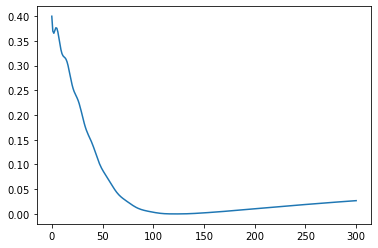

In [12]:
plt.plot(Mu_array[:,0,1])

In [13]:
ax.plot(Mu_array[:,0,0],Mu_array[:,0,1])
ax.scatter(Mu_array[-1,0,0],Mu_array[-1,0,1],c='g')
# ax.scatter(Mu_array[0,0,0],Mu_array[0,0,1],c='r')
ax.set_title('Find MAP by Adam',fontsize=20)
fig.savefig('/Users/zhouji/Documents/Presentations/IRTG 2020/figs/Adam.png',dpi=300)

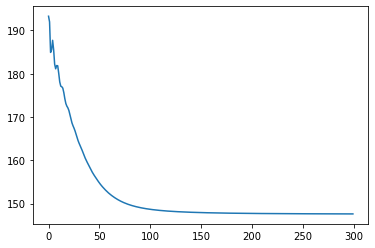

In [14]:
plt.plot(cost_A)

In [15]:
MAP = mu[-1]
MAP

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.16487178, 0.02676925], dtype=float32)>

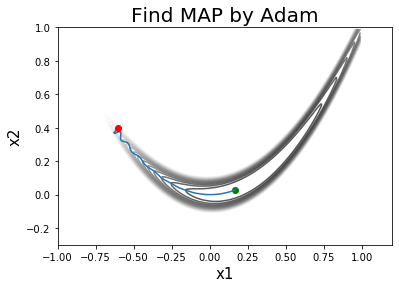

In [16]:
fig

In [17]:
def Hessian(MAP):
  Hess = tf.TensorArray(tf.float32, size=2)
  for i in range(2):

    tangents = np.zeros(MAP.shape)
    tangents[i]=1
    tangents = tf.convert_to_tensor(tangents,dtype=tf.float32)

    with tf.autodiff.ForwardAccumulator(MAP, tangents) as acc:
      with tf.GradientTape(watch_accessed_variables=False) as t:
        t.watch(MAP)
        joint_log =  loss(tf.expand_dims(MAP,axis=0))
      grad = t.gradient(joint_log,MAP)
    hess = acc.jvp(grad)
    Hess = Hess.write(i, hess)
    
  Hess = Hess.stack()
  grad = tf.reshape(grad,[grad.shape[0],1])

  return(grad,Hess)

  

In [18]:
start = timeit.default_timer()
grad,Hess = Hessian(MAP)
end = timeit.default_timer()
print('time for derivative calculation: %.3f' % (end - start))

time for derivative calculation: 4.735


In [19]:
Hess

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 103.88071, -259.61768],
       [-259.61768,  793.75385]], dtype=float32)>

In [20]:
def Laplace_approx(Hessian,C_prior):
    cov_post = tf.linalg.inv(
        (tf.add(Hessian, tf.linalg.inv(C_prior))))
    return cov_post

In [21]:
C_prior = tf.constant([[1,  0.], [0.,  1]])
cov_post = Laplace_approx(Hess,C_prior)

In [22]:
cov_post

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.04981843, 0.0162739 ],
       [0.0162739 , 0.00657435]], dtype=float32)>

In [23]:
from scipy.stats import multivariate_normal
loc  = MAP
cov = cov_post
x, y = np.mgrid[-0.5:0.7:.01, -0.3:0.3:.01]
pos = np.empty(x.shape + (2,)) 
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(loc, cov)
ax.set_title('Laplacian approximation at MAP',fontsize=20)
ax.contour(x, y, rv.pdf(pos),levels = 4,cmap = 'Blues')
# plt.xlabel("x1")
# plt.ylabel("x2")

In [24]:
fig.savefig('/Users/zhouji/Documents/Presentations/IRTG 2020/figs/Laplace_approx.png',dpi=300)

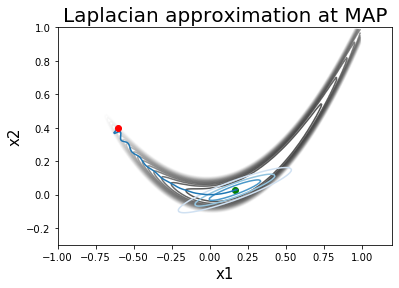

In [25]:
fig

## With local Hessian

## Newton Method
### Gaussian approximation

In [26]:
g,H = Hessian(MAP)

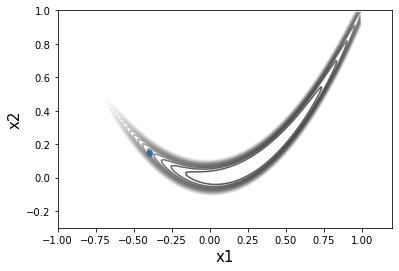

In [27]:
mu = tf.constant([-0.4,0.15],dtype=tf.float32)

# mu = MAP
fig1,ax1 = Bana_dist.draw_post()
ax1.scatter(mu[0],mu[1])

In [28]:
H_inv = np.linalg.inv(H)
np.dot(H_inv,tf.reshape(g,[2,1]))

array([[-0.0613624 ],
       [-0.02044914]], dtype=float32)

In [29]:
g,H=Hessian(mu)
# Gaussian approx proposal distribution with mean at (mu-H^-1 g)
#                                            cov at H^-1
def Gassian_approx(y,mu,H,g):
    H_inv = np.linalg.inv(H)
    loc = mu-np.squeeze(np.dot(H_inv,g))
    try: 
        tf.linalg.cholesky(H_inv)
        cov = H_inv
    except: # do eigen decomposition
        eigval,eigvec = np.linalg.eig(H_inv)
        eigval = np.where(eigval>0,eigval,1e-12)
        cov = eigvec @ np.diag(eigval)@eigvec.T
    rv = multivariate_normal(loc, cov)
    return rv.pdf(y)

In [30]:
H_inv = np.linalg.inv(H)
tf.reshape(mu,[mu.shape[0],1])-np.dot(H_inv,g)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.24490227],
       [ 0.03164239]], dtype=float32)>

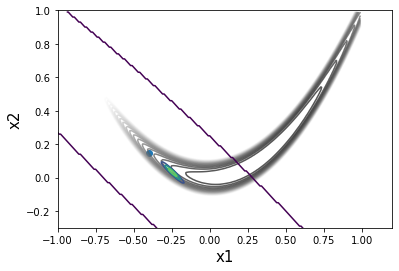

In [31]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.empty(x.shape + (2,)) 
pos[:, :, 0] = x; pos[:, :, 1] = y
ax1.contour(x,y,Gassian_approx(pos,mu,H,g),levels=3)
fig1

In [32]:
sys.path.append("/Users/zhouji/Google Drive/RWTH/")
from Newton import sNewton_MCMC,Mk

In [33]:
Number_para = 2
number_sample = 5000
number_burnin = 0
mu_init = tf.constant([[0.,0.]])
sNewton = sNewton_MCMC(Hessian,Number_para, negative_log_posterior, MAP, C_prior, number_sample, number_burnin, mu_init)

In [34]:
# mu = tf.constant([-0.4,0.15],dtype=tf.float32)
# mu = Mk(tf.expand_dims(mu,axis=0),Hessian)

# for i in range(1000):
#     s = sNewton.draw_proposal(mu).value
#     ax1.scatter(s[0,0],s[0,1],color ='red',alpha=0.2)
# fig1

In [35]:
accepted, rejected, samples = sNewton.run_chain_sNewton()
print(sNewton.acceptance_rate)

0.3618


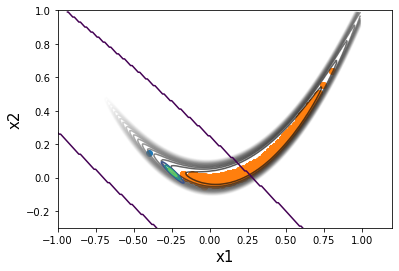

In [36]:
results = np.squeeze(np.array(samples))
ax1.scatter(results[:,0],results[:,1])
fig1

In [37]:
eigval,eigvec = tf.linalg.eigh(H_inv)
eigval = tf.where(eigval>0,eigval,1e-12)
cov = tf.matmul(tf.matmul(eigvec,tf.linalg.diag(eigval)),tf.transpose(eigvec))
tf.linalg.cholesky(cov)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.04626762,  0.        ],
       [-0.03819771,  0.01070579]], dtype=float32)>

In [38]:
cov

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.00214069, -0.00176732],
       [-0.00176732,  0.00157368]], dtype=float32)>

In [39]:
ev,ec = tf.linalg.eigh(cov)
ev

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([6.7273577e-05, 3.6470986e-03], dtype=float32)>

In [40]:

tf.linalg.cholesky(cov)
# cov = eigvec @ np.diag(eigval)@eigvec.T

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.04626762,  0.        ],
       [-0.03819771,  0.01070579]], dtype=float32)>

In [41]:
cov

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.00214069, -0.00176732],
       [-0.00176732,  0.00157368]], dtype=float32)>